##### Imports:

In [70]:
import torch
import torch.nn as nn
# deep learning

import numpy as np
# linear algebra

from scipy.integrate import solve_ivp
# dataset generaion solver

from torch.utils.data import DataLoader
# data handling

import matplotlib.pyplot as plt
# plotting

from tqdm import tqdm
# progrees tracking

#### Datset Generation (Synthetic But Correct as per SciPy)

In [71]:
def generate_ode_params(bound, n_samples=1000):
    # generate coeffs a,b,c and y_0, for dy/dx = ax + by + c, initial condition y_0.

    np.random.seed(42)
    
    params = []
    for _ in range(n_samples):

        a = np.random.uniform(-bound, bound)
        b = np.random.uniform(-bound, -bound)
        c = np.random.uniform(-bound, bound)
        y0 = np.random.uniform(-bound, bound)

        params.append((a, b, c, y0))
        
    return params


def solve_ode(a, b, c, y0, x_span=(0, 5), num_points=50):

    # solve dy/dx = ax + by + c with initial condition y_0 by enumeration

    # essentially, numerically solving and "plotting" the continuous curve at 50 points, 
    # in the interval (0,5)

    def ode_func(x, y):
        return a*x + b*y + c

    x_eval = np.linspace(x_span[0], x_span[1], num_points)
    # 50 points of a curve between 0 to 5

    sol = solve_ivp(ode_func, x_span, [y0], t_eval=x_eval, method='RK45')

    # sol.y[0] == solution for y at x_eval
    return x_eval, sol.y[0]


In [72]:
class ODEDataset_Linear(torch.utils.data.Dataset):
    def __init__(self, bound=0.25, n_samples=1000, x_span=(0, 5), num_points=50):
        self.x_eval = np.linspace(x_span[0], x_span[1], num_points)
        self.samples = []
        
        params_list = generate_ode_params(bound, n_samples)
        for a, b, c, y0 in params_list:
            _, y = solve_ode(a, b, c, y0, x_span, num_points)
            
            # store as (params, solution)
            self.samples.append( (np.array([a, b, c, y0], dtype=np.float32), y.astype(np.float32)) )
            # store the value of y for x = 5

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        params, y = self.samples[idx]
        return torch.from_numpy(params), torch.from_numpy(y)

##### Loading Model Architecture:

##### Hypernetwork
Trains the weights for the solution network (up next).

In [106]:
class HyperNet(nn.Module):
    def __init__(self, param_dim=4, hidden_dim=128, output_dim=49):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(param_dim, hidden_dim),
            # hidden layer, 64 dim
            nn.ReLU(),
            # V

            nn.Linear(hidden_dim, hidden_dim),
            # hidden layer, 64 dim
            nn.ReLU(),
            # V

            nn.Linear(hidden_dim, output_dim)
            # V (taken into SolnNet)
        )
    
    def forward(self, ode_params):
        return self.net(ode_params)

##### Solution Network
Given trained weights from Hypernetwork, makes a predection with a single layer neural network.

In [107]:
class SolutionNet(nn.Module):
    def forward(self, x, meta_params):

        # pytorch tensor operations-

        # meta_params - tensor of shape [batch_size, 25]
        

        # eg. hidden layer weight
        w1 = meta_params[:, :32].view(-1, 4, 8)
        # 1.  meta_params[:, (<- slice which takes from each batch,)  :16] <- 16 elements
        # 2. reshapes to tensor of shape [batch_size, 4, 4] 

        # eg. hidden layer bias
        b1 = meta_params[:, 32:40].view(-1, 8) 
        # 1.  meta_params[:, (<- slice which takes from each batch,)  16:20] <- elements 16 through 20-1 = 19
        # 2. reshapes to tensor of shape [batch_size, 4]

        # similarly,
        w2 = meta_params[:, 40:48].view(-1, 8, 1) # output layer weights
    
        b2 = meta_params[:, 48:49].view(-1, 1)    # output layer bias
    
        x = x.unsqueeze(-1).expand(-1, -1, 4)
        # Reshape: [batch, num_points] -> [batch, num_points, 1]

        h = torch.relu(torch.matmul(x, w1) + b1.unsqueeze(1))
        # b1.unsqueeze(1): [batch, 1, 4] 4 == num of hidden layers 

        # Compute (x @ w1) + b1,
        ## x: [batch, num_points, 1]
        # w1: [batch, 1, 4]
        # o/p: [batch, num_points, 4]

        return torch.matmul(h, w2) + b2.unsqueeze(1)
        # b2.unsqueeze(1): [batch, num_points]

        # Compute:(h @ w2) + b2
        # h: [batch, num_points, 4]
        # w2: [batch, 4, 1]
        # o/p: [batch, num_points, 1]


##### Extract pretrained model

Load from the saved models in the directory

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name())

checkpoint = torch.load('MeL-ODE_tuned.pt', map_location=device)

hyper_net = HyperNet(param_dim=4, hidden_dim=128, output_dim=49)
solution_net = SolutionNet()

hyper_net.to(device)
solution_net.to(device)

hyper_net.load_state_dict(checkpoint['hyper_param_net'])
solution_net.load_state_dict(checkpoint['solution_net'])

hyper_net.eval()
solution_net.eval()

print("Ready")

NVIDIA GeForce RTX 3050 Laptop GPU
Ready


##### Setting limits for generalization:
- We want to see how the trained model performs over different ranges of coefficients.
- For this, we increase our coefficient bounds from the initial $(-0.25,0.25)$ to $(-5,5)$ over a loop, and measure the loss.

In [117]:
b = 0.25

loss_fn = nn.MSELoss()

test_losses = []

avg_test_loss = 0

iters = 0

while avg_test_loss < 1:

    test_loss = 0.0
    gen_test_dataset = ODEDataset_Linear(bound=b, n_samples=1000)
    gen_test_loader = DataLoader(gen_test_dataset, batch_size=32)

    with torch.no_grad():
        for ode_params, y_true in gen_test_loader:
            ode_params = ode_params.to(device)
            y_true = y_true.to(device)
            
            meta_params = hyper_net(ode_params)
            # get meta parameters from coeffs
            x_points = torch.linspace(0, 5, y_true.shape[1], device=device).repeat(ode_params.shape[0], 1)

            y_pred = solution_net(x_points, meta_params).squeeze(-1)
            # get solutions from meta parameters and coeffs
            
            test_loss += loss_fn(y_pred, y_true).item() * ode_params.size(0)

    avg_test_loss = test_loss / len(gen_test_loader.dataset)

    #print(avg_test_loss)
    test_losses.append(avg_test_loss)

    b += 0.25
    iters += 1
    

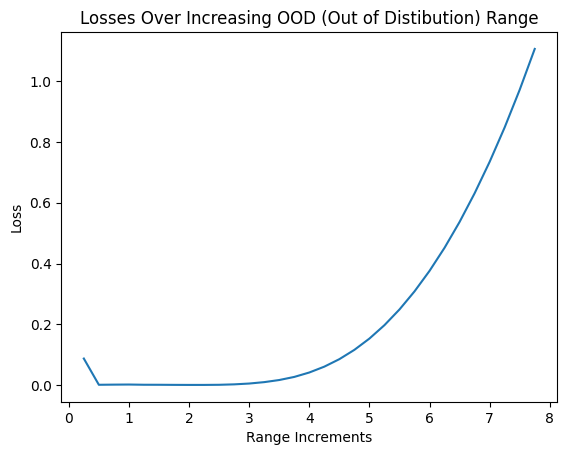

In [118]:
maxbound =  iters*0.25 + 0.25

plt.plot(np.arange(0.25, maxbound, 0.25), test_losses)
plt.title("Losses Over Increasing OOD (Out of Distibution) Range")
plt.xlabel("Range Increments")
plt.ylabel("Loss")
plt.show()